In [1]:
from base import *

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Example: Mandatory coin-flip example

In [2]:
rv_coin_flip_prior = tfd.Bernoulli(probs=0.5, dtype=tf.int32)
num_trials = np.array([0, 1, 2, 5, 8, 15, 50, 500, 1000, 2000])
data = rv_coin_flip_prior.sample(num_trials[-1])
data = tf.pad(data, [[1, 0]], "constant")
cumulative_headcounts = tf.gather(tf.cumsum(data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

xs = tf.linspace(0., 1., num=100, name="linspace")
ys = tf.transpose(rv_observed_heads.prob(xs[:, tf.newaxis]))

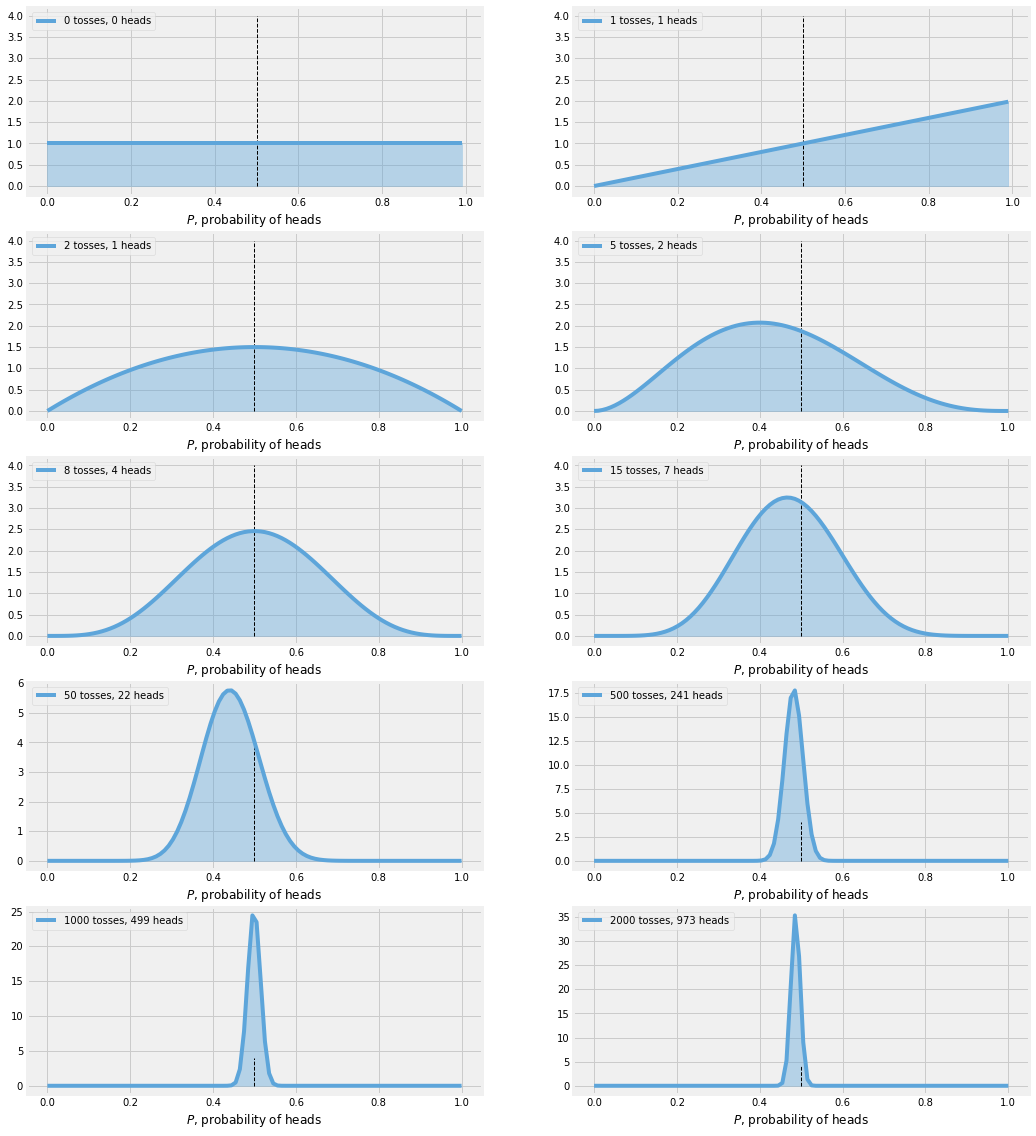

In [3]:
fig, axes = plt.subplots(nrows=len(num_trials) // 2, ncols=2, figsize=(16, 20))

for i, trial in enumerate(num_trials):
    ax = axes[i // 2, i % 2]
    ax.set_xlabel("$P$, probability of heads")
    ax.plot(xs, ys[i], label=f"{trial} tosses, {cumulative_headcounts[i]} heads", color=TFColor[3])
    ax.legend(loc="upper left")
    ax.fill_between(xs, 0, ys[i], color=TFColor[3], alpha=0.4)
    ax.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)


## Example: Inferring behaviour from text-message data

(0.0, 74.0)

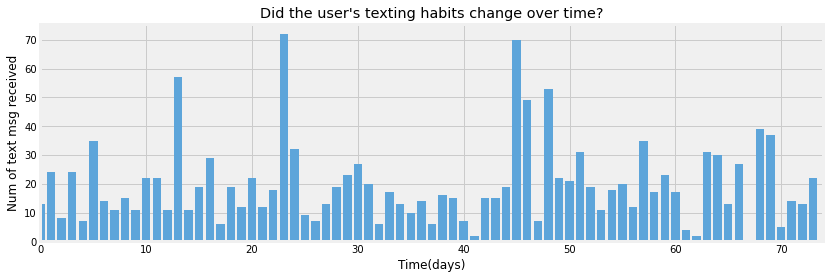

In [4]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
n_count_data = len(count_data)
days = tf.range(n_count_data, dtype=tf.int32)

plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time(days)")
plt.ylabel("Num of text msg received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

In [5]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    alpha = 1. / tf.reduce_mean(count_data)
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    
    n = tf.size(count_data)
    days = tf.range(n)
    
    rv_tau = tfd.Uniform()
    thresh = tau * tf.cast(n, dtype=tf.float32)
    lambda_ = tf.gather([lambda_1, lambda_2], 
                        tf.cast(thresh <= tf.cast(days, dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
    return tf.reduce_sum(rv_observation.log_prob(count_data))\
            + rv_tau.log_prob(tau)\
            + rv_lambda_1.log_prob(lambda_1)\
            + rv_lambda_2.log_prob(lambda_2)

def unnormalized_log_posterior(lambda_1, lambda_2, tau):
    return joint_log_prob(count_data, lambda_1, lambda_2, tau)

In [ ]:
initial_chain_state = [np.mean(count_data), np.mean(count_data), 0.5]   

inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_posterior,
    num_leapfrog_steps=2, step_size=0.2, 
    state_gradients_are_stopped=True)

@tf.function
def run_chain(initial_state, num_results=20000, num_burnin_steps=5000):
    
#     transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
#         inner_kernel=inner_kernel, bijector=[tfb.Exp(), tfb.Exp(), tfb.Sigmoid()]
#     )
    
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        num_adaptation_steps=int(0.8 * num_burnin_steps)
    )
    return tfp.mcmc.sample_chain(
        num_results=num_results, 
        num_burnin_steps=num_burnin_steps, 
        kernel=adaptive_kernel,
        current_state=initial_state)

(lambda_1_samples, lambda_2_samples, posterior_tau), kernel_results =\
    run_chain(initial_chain_state)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
